# Investigate which distribution best fit yearly prices & Correlation 

In [7]:
import pandas as pd
import glob
import os
from distfit import distfit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import stats
from scipy.stats import expon,t
import numpy as np

# Read CSV and convert commas to dots for numeric columns
df = pd.read_csv("EnergyReport.csv", sep=";", decimal=",")
df = df.drop(columns=['HourDK'])
df.index = pd.to_datetime(df["HourUTC"])
df = df.drop(columns=['HourUTC'])

In [8]:
df

,OnshoreWindGe50kW_MWhDK1,OnshoreWindGe50kW_MWhDK2,DK2_EUR/MWh
HourUTC,,,
2019-12-31 23:00:00,784.395569,229.717789,33.419998
2020-01-01 00:00:00,972.303528,204.677185,31.770000
2020-01-01 01:00:00,1169.856934,214.743927,31.570000
2020-01-01 02:00:00,1469.282471,221.410843,31.280001
2020-01-01 03:00:00,1634.739258,238.787140,30.850000
...,...,...,...
2025-06-29 17:00:00,2637.144782,461.859933,59.700001
2025-06-29 18:00:00,2509.297894,437.731971,105.660004
2025-06-29 19:00:00,2270.735150,401.459270,117.430000


# Find Best Distribution for yearly prices

In [9]:
yearly_df = df.resample('Y').sum()
# Print statistics for each column
for column in yearly_df.columns:
    print(f"\n{column}:")
    print(f"Average: {yearly_df[column].mean():.2f}")
    print(f"Std Dev: {yearly_df[column].std():.2f}")


OnshoreWindGe50kW_MWhDK1:
Average: 6530427.08
Std Dev: 3359164.59

OnshoreWindGe50kW_MWhDK2:
Average: 1299694.81
Std Dev: 674959.48

DK2_EUR/MWh:
Average: 650504.74
Std Dev: 592720.92


[04-08-2025 00:15:52] [distfit.distfit] [INFO] fit
[04-08-2025 00:15:52] [distfit.distfit] [INFO] transform
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [norm      ] [0.00 sec] [RSS: 5.659] [loc=0.412 scale=0.428]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [expon     ] [0.00 sec] [RSS: 1.71251] [loc=0.017 scale=0.395]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [pareto    ] [0.00 sec] [RSS: 1.13513] [loc=-1.352 scale=1.370]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [dweibull  ] [0.00 sec] [RSS: 4.74255] [loc=0.287 scale=0.341]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [t         ] [0.04 sec] [RSS: 0.508336] [loc=0.145 scale=0.097]


Data shape after outlier removal: (46985, 3)


[04-08-2025 00:15:52] [distfit.distfit] [INFO] [genextreme] [0.03 sec] [RSS: 0.538557] [loc=0.143 scale=0.144]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [gamma     ] [0.03 sec] [RSS: 1.39467] [loc=0.017 scale=0.604]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [lognorm   ] [0.00 sec] [RSS: 0.598672] [loc=0.009 scale=0.210]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [beta      ] [0.04 sec] [RSS: 2.89725] [loc=0.017 scale=1.695]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [uniform   ] [0.00 sec] [RSS: 6.36103] [loc=0.017 scale=1.687]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [loggamma  ] [0.03 sec] [RSS: 5.66148] [loc=-134.024 scale=18.091]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [norm      ] [0.21 sec] [RSS: 5.659] [loc=0.412 scale=0.428]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [expon     ] [0.21 sec] [RSS: 1.71251] [loc=0.017 scale=0.395]
[04-08-2025 00:15:52] [distfit.distfit] [INFO] [pareto    ] [0.21 sec] [RSS: 1.13513] [loc=-1.352 scale=1.370]
[04-0

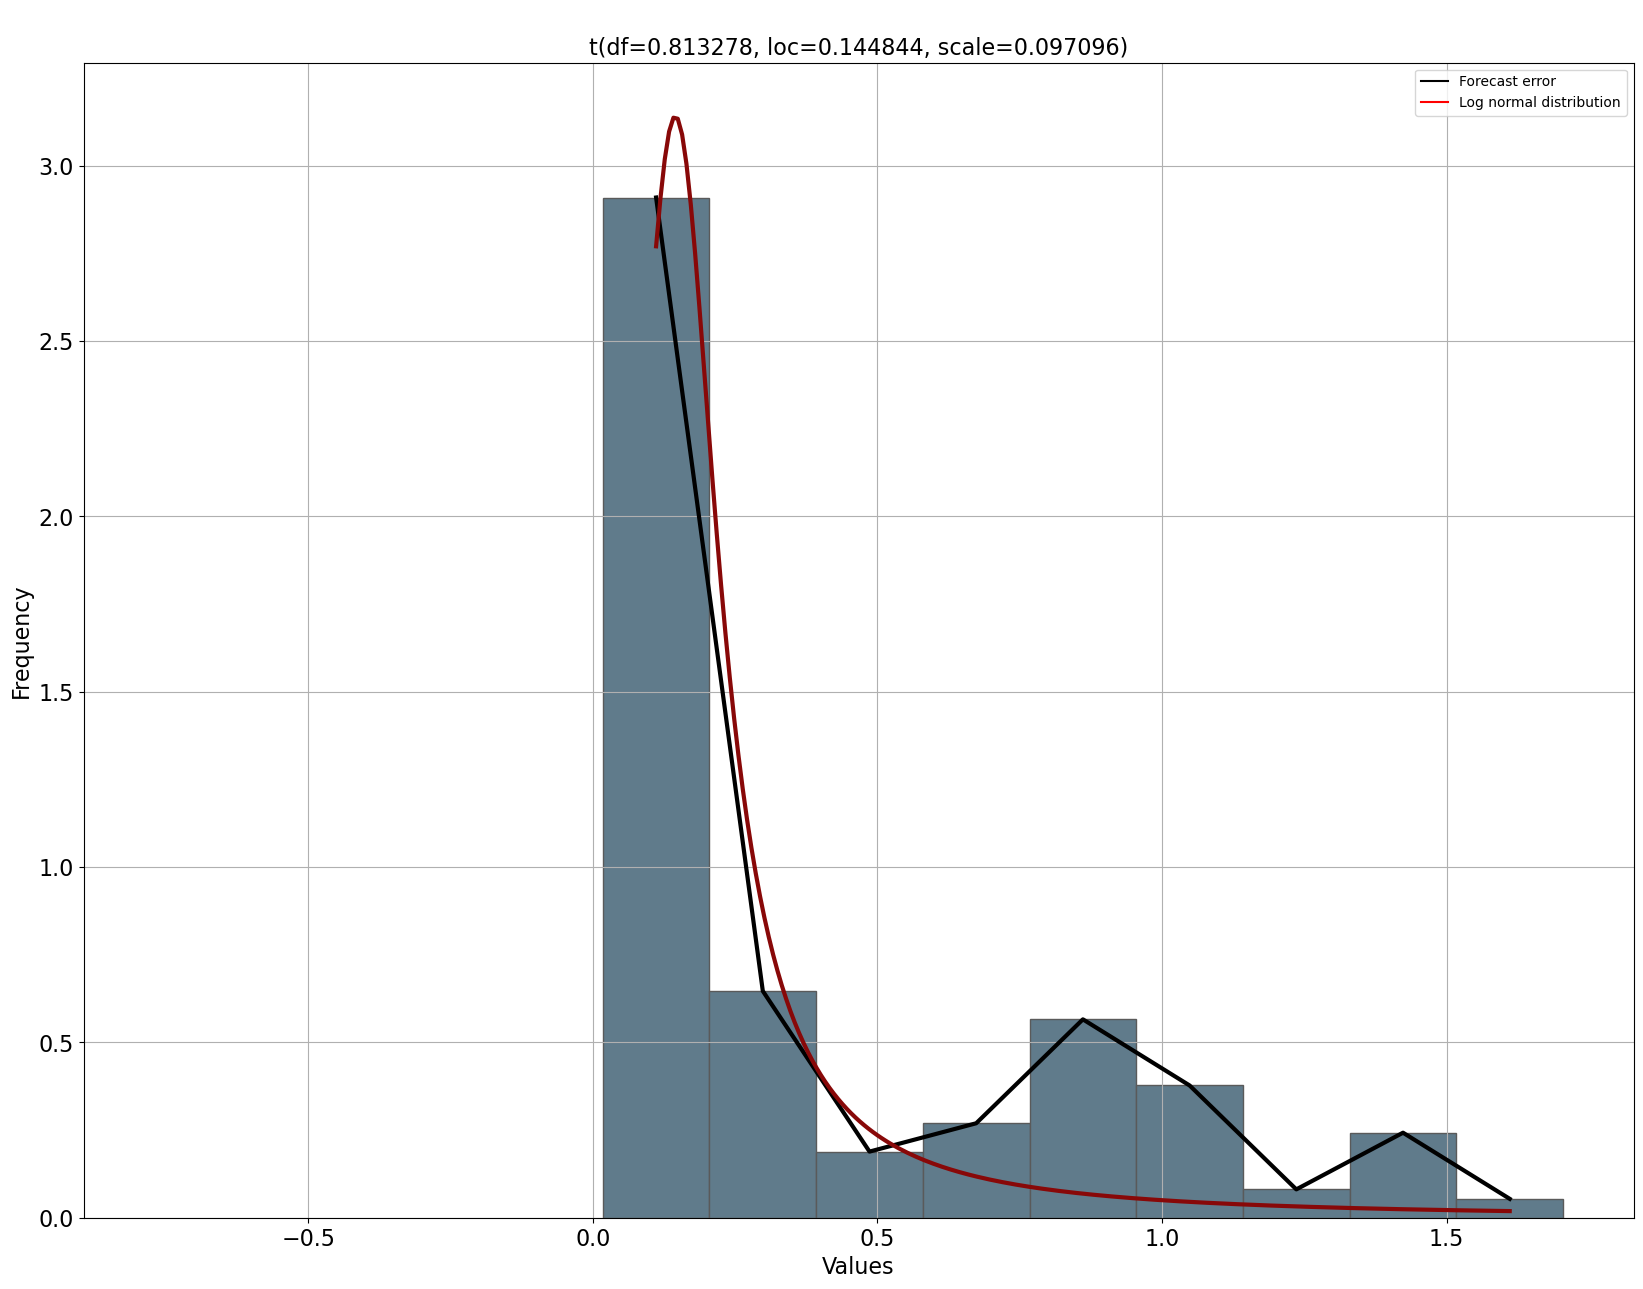

In [10]:
price_col = 'DK2_EUR/MWh'
mean_price = df[price_col].mean()
std_price = df[price_col].std()
df_clean = df[(df[price_col] > mean_price - 3*std_price) & 
              (df[price_col] < mean_price + 3*std_price)]

print("Data shape after outlier removal:", df_clean.shape)

#df_clean = df_clean[df_clean[price_col] > 0]

monthly_df = df_clean.resample('ME').mean().to_numpy(float) * 1e-3
dist_monthly = distfit()
# Find best theoretical distribution for empirical data X
dist_monthly.fit_transform(monthly_df[1:])
fig, ax = dist_monthly.plot()
ax.lines[-1].remove()
ax.lines[-1].remove()
l1 = Line2D([0], [0], color='black', label="Forecast error")
l2 = Line2D([0], [0], color='red', label="Log normal distribution")
handles = [l1, l2]
ax.legend(handles=handles)

# Find Correlation between Onshore production and Energy Prices

In [11]:
df_corr = df
df_corr  = df.resample('H').sum()


# Mean and std for price 
price_mu, price_std = df_corr['DK2_EUR/MWh'].mean(), df_corr['DK2_EUR/MWh'].std() # EUR/MWh

# Mean and std for production
prod_mu, prod_std = df_corr['OnshoreWindGe50kW_MWhDK2'].mean(), df_corr['OnshoreWindGe50kW_MWhDK2'].std() # MWh

corr = df_corr['DK2_EUR/MWh'].corr(df_corr['OnshoreWindGe50kW_MWhDK2'])


CR = 1 + corr * (prod_std / prod_mu) * (price_std / price_mu)
print(f"\nCorrelation between price and production: {corr:.2f}")
print(f"Capture Rate : {CR:.2f}")


Correlation between price and production: -0.34
Capture Rate : 0.69


# Load Profile 

[04-08-2025 00:15:53] [distfit.distfit] [INFO] fit
[04-08-2025 00:15:53] [distfit.distfit] [INFO] transform
[04-08-2025 00:15:53] [distfit.distfit] [INFO] [norm      ] [0.00 sec] [RSS: 1.21073e-08] [loc=16494.045 scale=4835.739]
[04-08-2025 00:15:53] [distfit.distfit] [INFO] [expon     ] [0.00 sec] [RSS: 9.1249e-08] [loc=3055.487 scale=13438.558]
[04-08-2025 00:15:53] [distfit.distfit] [INFO] [pareto    ] [0.02 sec] [RSS: 9.1249e-08] [loc=-2199023252496.513 scale=2199023255552.000]
[04-08-2025 00:15:53] [distfit.distfit] [INFO] [dweibull  ] [0.20 sec] [RSS: 1.26342e-08] [loc=16639.643 scale=4437.249]
[04-08-2025 00:15:55] [distfit.distfit] [INFO] [t         ] [1.41 sec] [RSS: 1.21085e-08] [loc=16494.328 scale=4835.824]
[04-08-2025 00:15:55] [distfit.distfit] [INFO] [genextreme] [0.97 sec] [RSS: 1.40487e-08] [loc=12790.144 scale=4451.883]
[04-08-2025 00:15:56] [distfit.distfit] [INFO] [gamma     ] [0.10 sec] [RSS: 4.87803e-09] [loc=1921.260 scale=1614.937]
[04-08-2025 00:15:56] [distfit

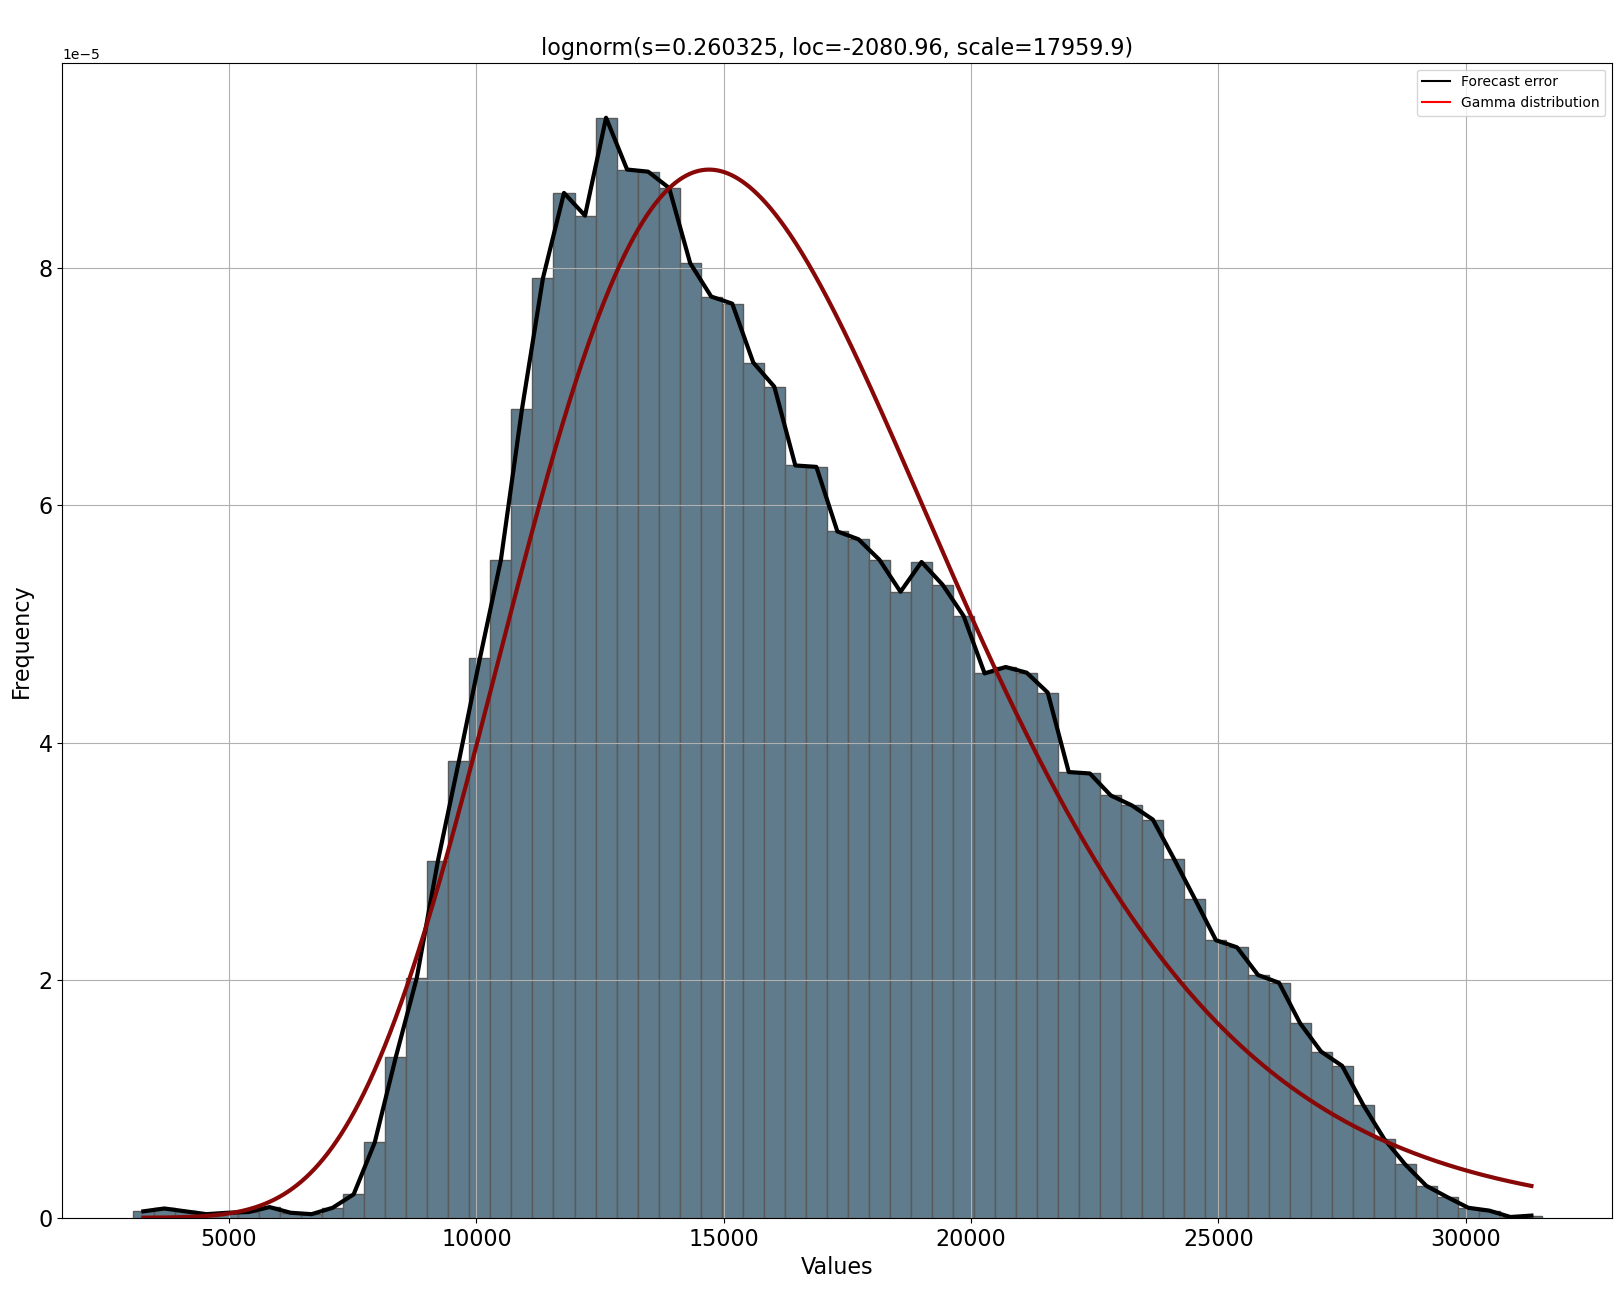

In [12]:
dist_hourly_consumption = distfit()
# Load hourly consumption data
df_cons = pd.read_csv("ConsumptionIndustry.csv", sep=";", decimal=",")
df_cons["HourUTC"] = pd.to_datetime(df_cons["HourUTC"])
df_cons = df_cons.set_index("HourUTC")
df_cons.drop(columns=['HourDK','MunicipalityNo'], inplace=True)
# Only keep rows where 'Branche' == 'Erhverv'
df_cons = df_cons[df_cons['Branche'] == 'Erhverv']

# Find best theoretical distribution for empirical data X
dist_hourly_consumption.fit_transform(df_cons['ConsumptionkWh'][1:])
fig, ax = dist_hourly_consumption.plot()
ax.lines[-1].remove()
ax.lines[-1].remove()
l1 = Line2D([0], [0], color='black', label="Forecast error")
l2 = Line2D([0], [0], color='red', label="Gamma distribution")
handles = [l1, l2]
ax.legend(handles=handles)

[04-08-2025 00:15:57] [distfit.distfit] [INFO] fit
[04-08-2025 00:15:57] [distfit.distfit] [INFO] transform
[04-08-2025 00:15:57] [distfit.distfit] [INFO] [norm      ] [0.00 sec] [RSS: 2.4875e-14] [loc=12021715.088 scale=1523165.414]
[04-08-2025 00:15:57] [distfit.distfit] [INFO] [expon     ] [0.00 sec] [RSS: 7.91497e-14] [loc=9194646.774 scale=2827068.314]
[04-08-2025 00:15:57] [distfit.distfit] [INFO] [pareto    ] [0.00 sec] [RSS: 2.02082e-13] [loc=9194646.774 scale=0.000]
[04-08-2025 00:15:57] [distfit.distfit] [INFO] [dweibull  ] [0.01 sec] [RSS: 1.97735e-14] [loc=11812901.919 scale=1284010.877]
[04-08-2025 00:15:57] [distfit.distfit] [INFO] [t         ] [0.07 sec] [RSS: 2.4875e-14] [loc=12021715.104 scale=1523165.443]
[04-08-2025 00:15:57] [distfit.distfit] [INFO] [genextreme] [0.10 sec] [RSS: 1.95917e-13] [loc=9194646.876 scale=1.055]
[04-08-2025 00:15:57] [distfit.distfit] [INFO] [gamma     ] [0.03 sec] [RSS: 2.047e-14] [loc=6681950.759 scale=445931.608]
[04-08-2025 00:15:57] [d

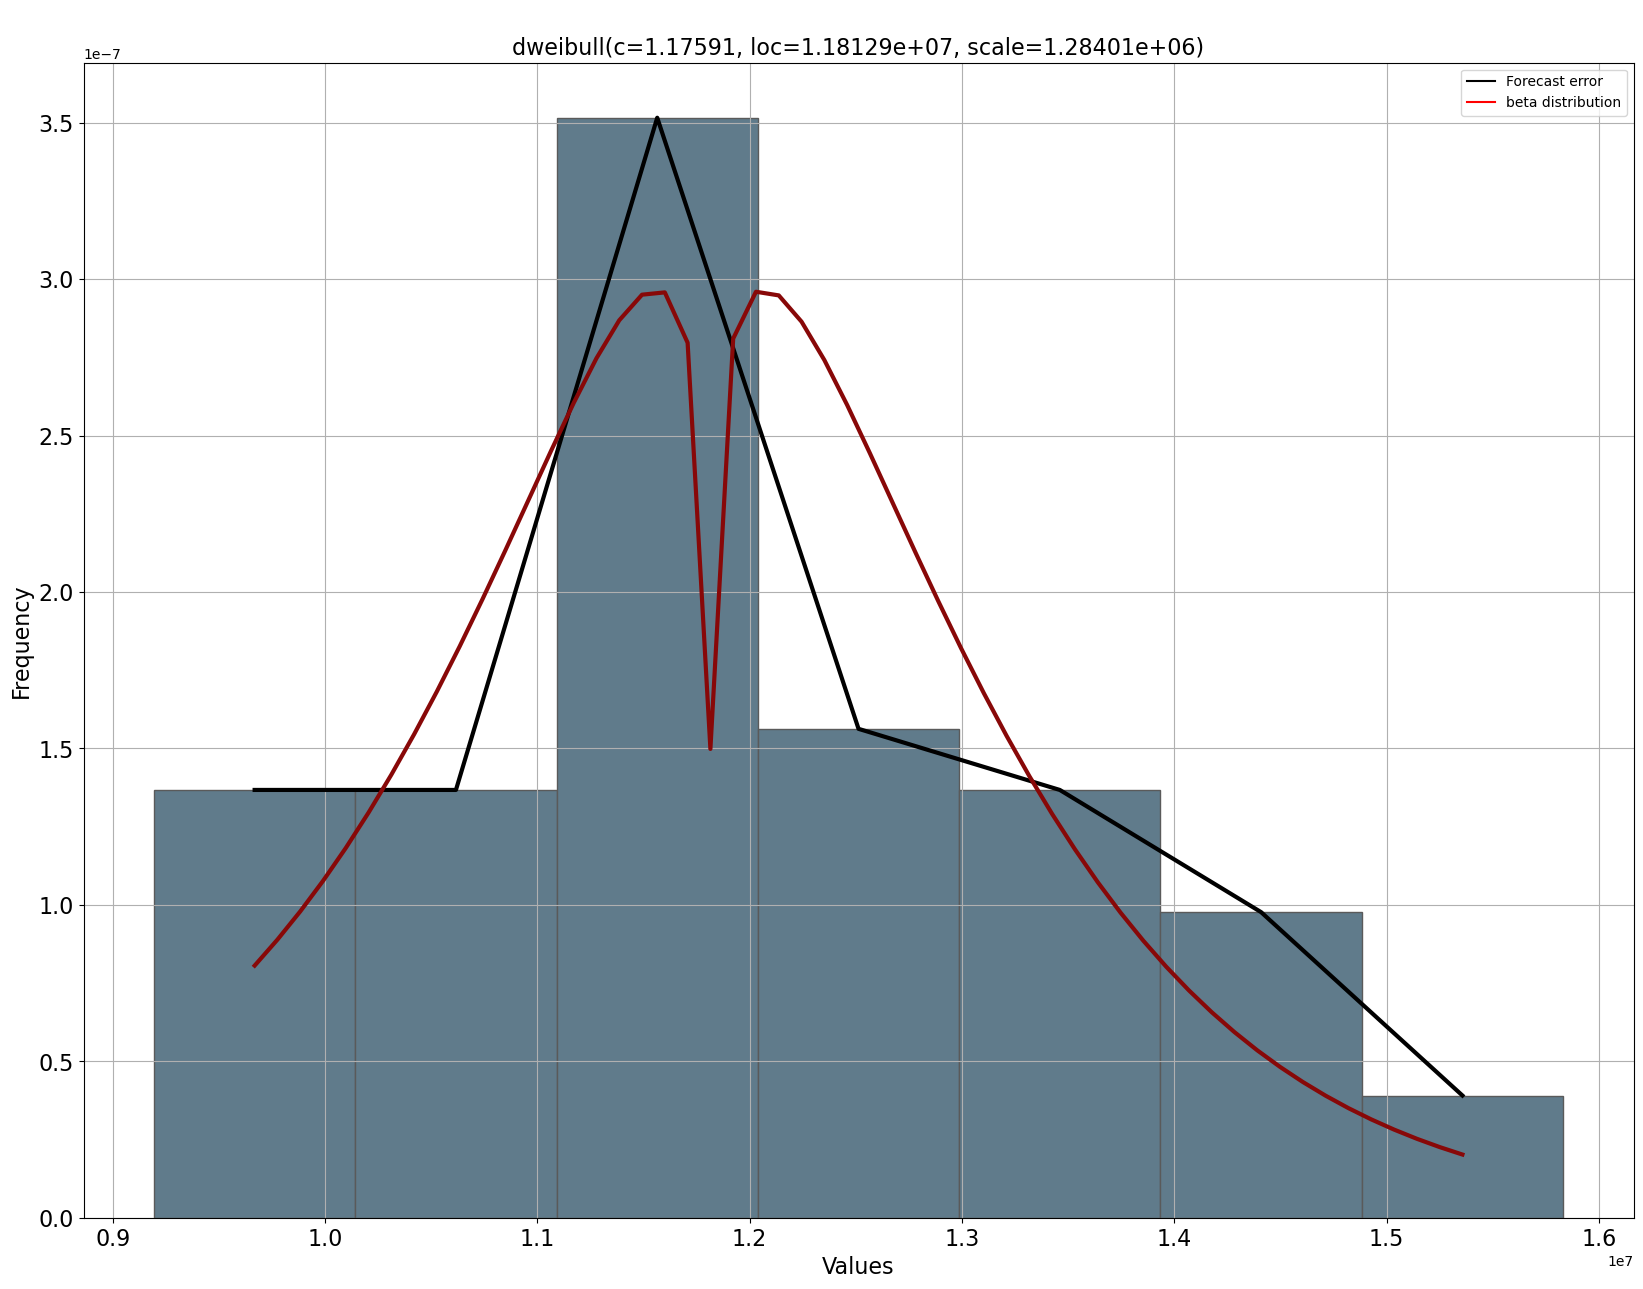

In [13]:
yearly_df_consumption = df_cons.resample('ME').sum()
dist_monthly_consumption = distfit()
# Find best theoretical distribution for empirical data X
dist_monthly_consumption.fit_transform(yearly_df_consumption['ConsumptionkWh'][1:].values)
fig, ax = dist_monthly_consumption.plot()
ax.lines[-1].remove()
ax.lines[-1].remove()
l1 = Line2D([0], [0], color='black', label="Forecast error")
l2 = Line2D([0], [0], color='red', label="beta distribution")
handles = [l1, l2]
ax.legend(handles=handles)

In [14]:
df_corr = df

# Mean and std for Consumption 
consump_mu, consump_std = df_corr['GrossConsumptionMWhDK2'].mean(), df_corr['GrossConsumptionMWhDK2'].std() # MWh

corr = df_corr['DK2_EUR/MWh'].corr(df_corr['GrossConsumptionMWhDK2'])


CR = 1 + corr * (consump_std / consump_mu) * (price_std / price_mu)
print(f"\nCorrelation between price and consumption: {corr:.2f}")
print(f"Capture Rate : {CR:.2f}")

KeyError: 'GrossConsumptionMWhDK2'

10.691018777670205
64.29620205491169


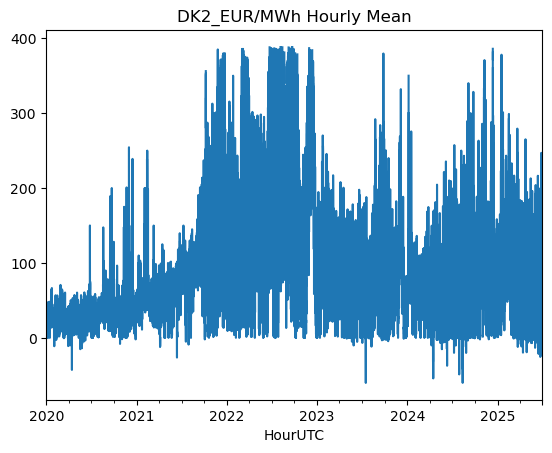

In [15]:
# Random Walk Test code 

df_clean["DK2_EUR/MWh"][1:].resample('H').mean().plot(title="DK2_EUR/MWh Hourly Mean")
df_price_year = df_clean["DK2_EUR/MWh"][1:].resample('Y').mean()
print(df_price_year.diff().mean())
print(df_price_year.diff().std())


Starting value: 54.93, Long-term mean: 57.39, Std Dev of monthly differences: 31.05
Estimated OU parameters (MLE-based):
  κ (mean reversion speed) = 0.1693 per year
  θ (long-run mean)        = 70.40 EUR/MWh
  σ (volatility)           = 14.42 EUR/MWh/year^0.5


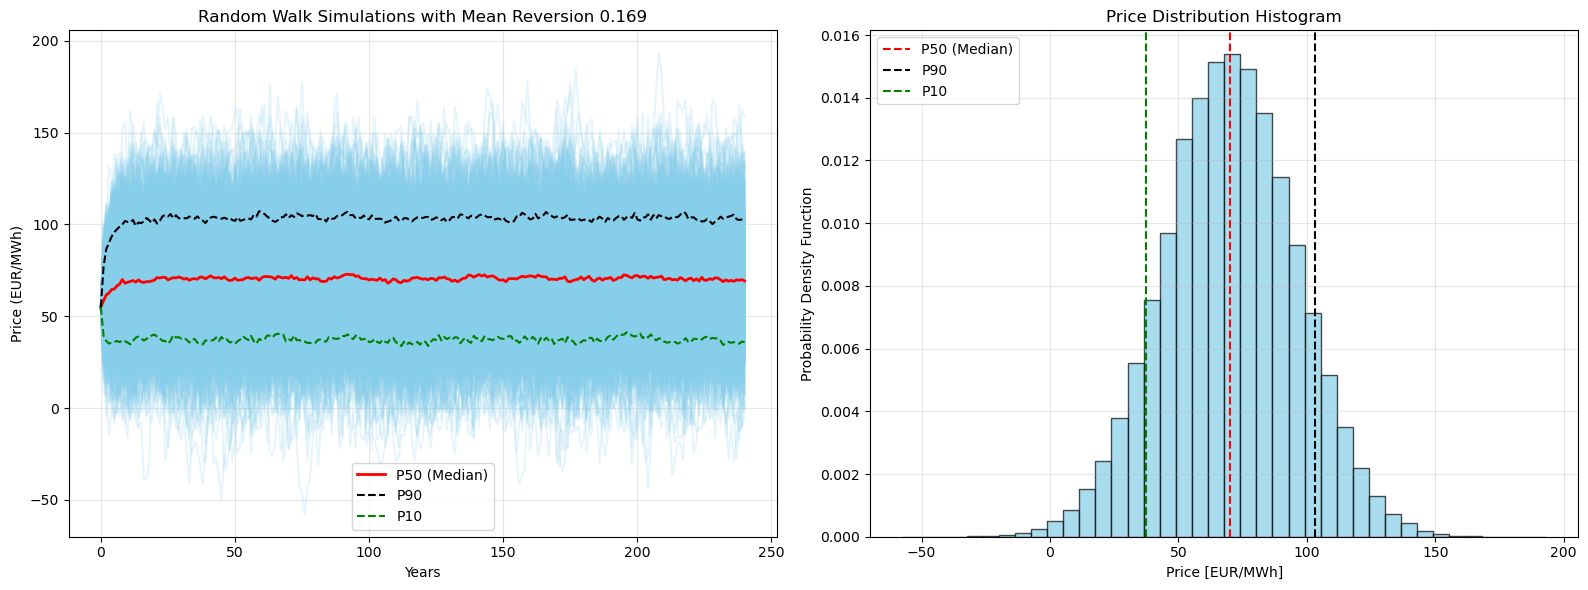

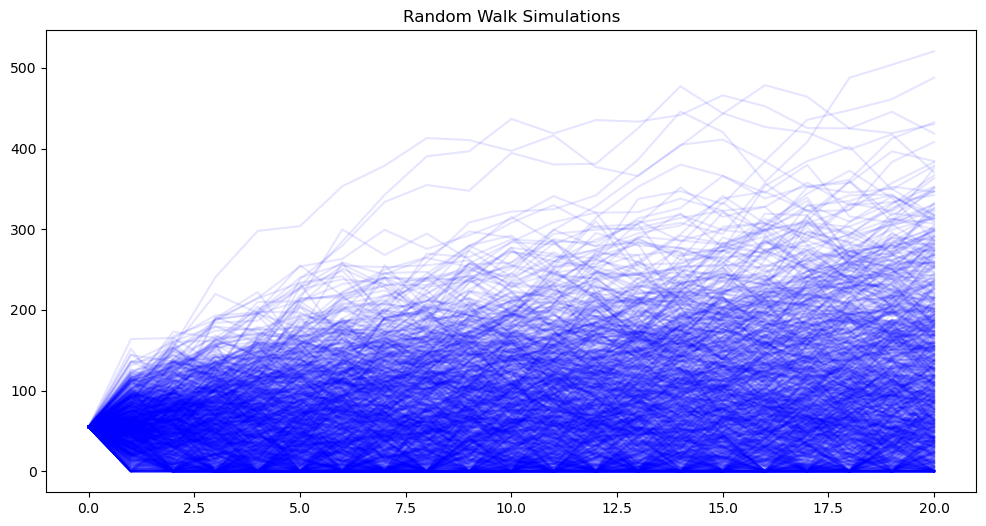

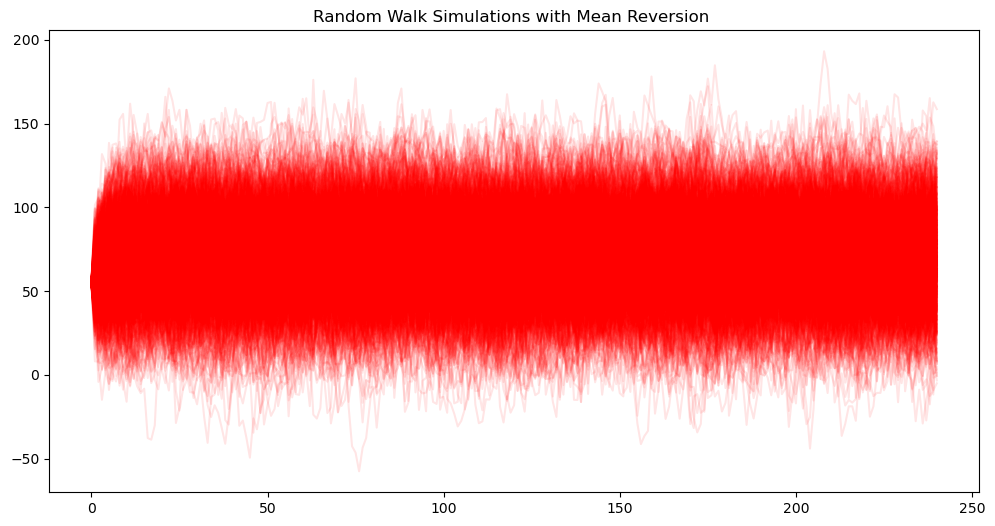

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns
import statsmodels.api as sm


# --- Corrected Simulation Setup ---
T = 20  # Simulation horizon in years
n_sim = 1000  # Number of simulations
dt = 1  # Time step in years (monthly)
n_steps = int(T / dt)  # Total number of monthly steps

df_price_monthly = df_clean["DK2_EUR/MWh"][1:].resample('M').mean()
start_value = df_price_monthly.iloc[-1]
long_term_mean = df_price_monthly.mean()-30
monthly_diff = df_price_monthly.diff().dropna()
sigma_diff = monthly_diff.std()
print(f"Starting value: {start_value:.2f}, Long-term mean: {long_term_mean:.2f}, Std Dev of monthly differences: {sigma_diff:.2f}")


# Step 1: Prepare time series
X = df_price_monthly.values # In months
X_t = X[:-1]
X_tp1 = X[1:]

dX_dt = (X_tp1 - X_t) / (1) # Time step in months (would be 1/12 if in years)

# Step 2: Linear regression dX/dt = a + b X_t
import statsmodels.api as sm
X_t_with_const = sm.add_constant(X_t)
model = sm.OLS(dX_dt, X_t_with_const)
results = model.fit()

# Step 3: Extract OU parameters
a = results.params[0]
b = results.params[1]
kappa = -b
theta = -a / b -20
sigma = results.resid.std() * np.sqrt(1)-15

print(f"Estimated OU parameters (MLE-based):")
print(f"  κ (mean reversion speed) = {kappa:.4f} per year")
print(f"  θ (long-run mean)        = {theta:.2f} EUR/MWh")
print(f"  σ (volatility)           = {sigma:.2f} EUR/MWh/year^0.5")


all_simulations_nodrift = []
all_simulations_drift = []


mean_reversion_speed = kappa # Adjust based on your data

for i in range(n_sim):
    random_walk = [start_value]
    for j in range(n_steps*12):
        mean_reversion = mean_reversion_speed * (theta - random_walk[-1]) * dt
        random_component = np.random.normal(0, 1) * sigma * np.sqrt(dt)
        next_value = random_walk[-1] + mean_reversion + random_component
        #random_walk.append(max(next_value, 0)) # Ensure non-negative prices
        random_walk.append(next_value)
    all_simulations_drift.append(random_walk)

all_simulations_drift = np.array(all_simulations_drift)


#Without drift
for i in range(n_sim):
    random_walk = [start_value]
    for j in range(n_steps):
        next_value = random_walk[-1] + np.random.normal(0, 1) * sigma_diff * np.sqrt(dt)  # Scale by sqrt(dt) where dt=1 year
        random_walk.append(max(next_value, 0)) # Ensure non-negative prices
    all_simulations_nodrift.append(random_walk)




time_grid = np.arange(0, (T*12) + dt, dt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# Plot individual simulation paths (transposed)
ax1.plot(time_grid, all_simulations_drift.T, color='skyblue', alpha=0.2)

# Calculate statistics across simulations (axis=0)
mean_path = np.mean(all_simulations_drift, axis=0)
median_path = np.median(all_simulations_drift, axis=0)
p10 = np.percentile(all_simulations_drift, 10, axis=0)
p90 = np.percentile(all_simulations_drift, 90, axis=0)

# Plot statistics with the correct time_grid on the x-axis
ax1.plot(time_grid, median_path, 'g-', linewidth=2,color="red", label='P50 (Median)')
ax1.plot(time_grid, p90, 'k--',color ="black", linewidth=1.5, label='P90')
ax1.plot(time_grid, p10, 'k--',color= "green", linewidth=1.5, label='P10')


ax1.set_title(f"Random Walk Simulations with Mean Reversion {mean_reversion_speed:.3f}")
ax1.set_xlabel("Years")
ax1.set_ylabel("Price (EUR/MWh)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot distribution of final prices
#first_price = all_simulations_drift[0, :]
final_prices = all_simulations_drift[-1, :]
#sns.histplot(first_price, kde=False, ax=ax2)

# Histogram of all values
ax2.hist(all_simulations_drift.flatten(),bins=40, color='skyblue',density=True, edgecolor='black', alpha=0.7)
ax2.axvline(np.median(all_simulations_drift.flatten()), color='red', linestyle='--', label='P50 (Median)')
ax2.axvline(np.percentile(all_simulations_drift.flatten(), 90), color='black', linestyle='--', label='P90')
ax2.axvline(np.percentile(all_simulations_drift.flatten(), 10), color='green', linestyle='--', label='P10')
ax2.set_title('Price Distribution Histogram')
ax2.set_xlabel("Price [EUR/MWh]")
ax2.set_ylabel('Probability Density Function')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(np.array(all_simulations_nodrift).T, color='blue', alpha=0.1)
plt.title("Random Walk Simulations")
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(np.array(all_simulations_drift).T, color='red', alpha=0.1)
plt.title("Random Walk Simulations with Mean Reversion ")
#create histogram of ending stock values for our mutliple simulations
plt.show()


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     3.016
Date:                Mon, 04 Aug 2025   Prob (F-statistic):             0.0563
Time:                        00:23:10   Log-Likelihood:                -150.51
No. Observations:                  65   AIC:                             307.0
Df Residuals:                      62   BIC:                             313.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3512      0.738      1.832      0.0

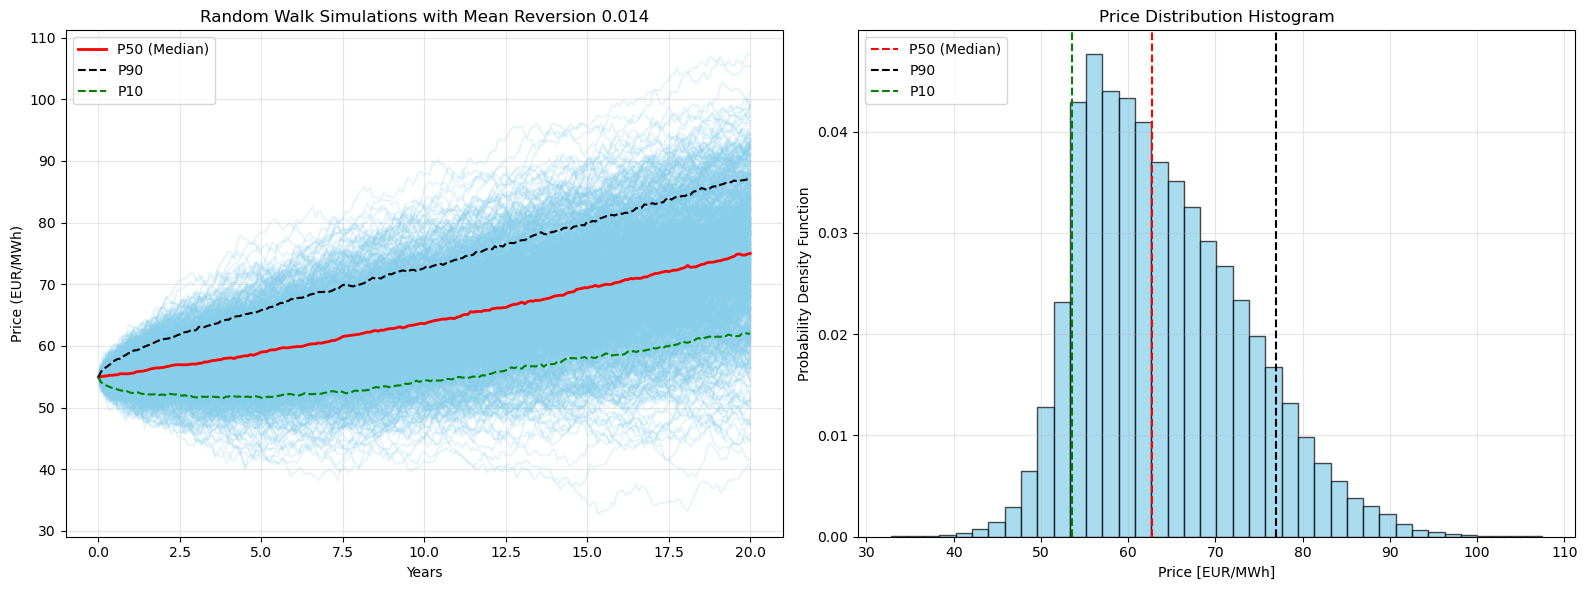

In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- Step 1: Prepare Time Series Data ---
X = df_price_monthly.values  # Monthly price series (must be regularly spaced)
X_t = X[:-1]
X_tp1 = X[1:]

dt = 1/12  # time step in months (change to 1/12 if you want years)
dX_dt = (X_tp1 - X_t) / (12)

N = len(X_t)
t_idx = np.arange(N)  # time index: 0, 1, 2, ..., N-1

# --- Step 2: Set Up Regression Matrix with X_t and t_idx as Regressors ---
# dX_dt = intercept + c1 * X_t + c2 * t_idx
X_reg = np.column_stack([X_t, t_idx])
X_reg_with_const = sm.add_constant(X_reg)

model = sm.OLS(dX_dt, X_reg_with_const)
results = model.fit()
print(results.summary())

# --- Step 3: Extract OU Parameters (theta, a, b) ---
c0, c1, c2 = results.params  # Intercept, X_t, t_idx

theta = -c1
a = c0 / theta
b = c2 / theta

print(f"Estimated OU parameters for linear mean:")
print(f"  θ (mean reversion speed) = {theta:.4f} per month")
print(f"  a (intercept for μ(t))   = {a:.4f} (in price units)")
print(f"  b (slope for μ(t))       = {b:.4f} (in price units per month)")

# --- Step 4: Estimate Volatility from Residuals ---
sigma = results.resid.std() * np.sqrt(1)
print(f"  σ (volatility)           = {sigma:.4f} (in price units per sqrt(month))")

# --- Step 5: (Optional) Forecast or Simulate Using the Fitted Model ---
# μ(t) = a + b*t
# X_{t+1} = X_t + θ(a + b*t - X_t)*dt + σ*sqrt(dt)*N(0,1)

mean_reversion_speed = theta  # use estimated theta from regression

all_simulations_drift = []

for i in range(n_sim):
    random_walk = [start_value]
    for j in range(n_steps):
        t_future = len(X) + j  # forecast time index
        mu_t = a - b * t_future
        mean_reversion = mean_reversion_speed * (mu_t - random_walk[-1]) * dt
        random_component = np.random.normal(0, 1) * sigma * np.sqrt(dt)
        next_value = random_walk[-1] + mean_reversion + random_component
        random_walk.append(next_value)
    all_simulations_drift.append(random_walk)

all_simulations_drift = np.array(all_simulations_drift)


time_grid = np.arange(0, T + dt, dt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# Plot individual simulation paths (transposed)
ax1.plot(time_grid, all_simulations_drift.T, color='skyblue', alpha=0.2)

# Calculate statistics across simulations (axis=0)
mean_path = np.mean(all_simulations_drift, axis=0)
median_path = np.median(all_simulations_drift, axis=0)
p10 = np.percentile(all_simulations_drift, 10, axis=0)
p90 = np.percentile(all_simulations_drift, 90, axis=0)

# Plot statistics with the correct time_grid on the x-axis
ax1.plot(time_grid, median_path, 'g-', linewidth=2,color="red", label='P50 (Median)')
ax1.plot(time_grid, p90, 'k--',color ="black", linewidth=1.5, label='P90')
ax1.plot(time_grid, p10, 'k--',color= "green", linewidth=1.5, label='P10')


ax1.set_title(f"Random Walk Simulations with Mean Reversion {mean_reversion_speed:.3f}")
ax1.set_xlabel("Years")
ax1.set_ylabel("Price (EUR/MWh)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot distribution of final prices
#first_price = all_simulations_drift[0, :]
final_prices = all_simulations_drift[-1, :]
#sns.histplot(first_price, kde=False, ax=ax2)

# Histogram of all values
ax2.hist(all_simulations_drift.flatten(),bins=40, color='skyblue',density=True, edgecolor='black', alpha=0.7)
ax2.axvline(np.median(all_simulations_drift.flatten()), color='red', linestyle='--', label='P50 (Median)')
ax2.axvline(np.percentile(all_simulations_drift.flatten(), 90), color='black', linestyle='--', label='P90')
ax2.axvline(np.percentile(all_simulations_drift.flatten(), 10), color='green', linestyle='--', label='P10')
ax2.set_title('Price Distribution Histogram')
ax2.set_xlabel("Price [EUR/MWh]")
ax2.set_ylabel('Probability Density Function')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



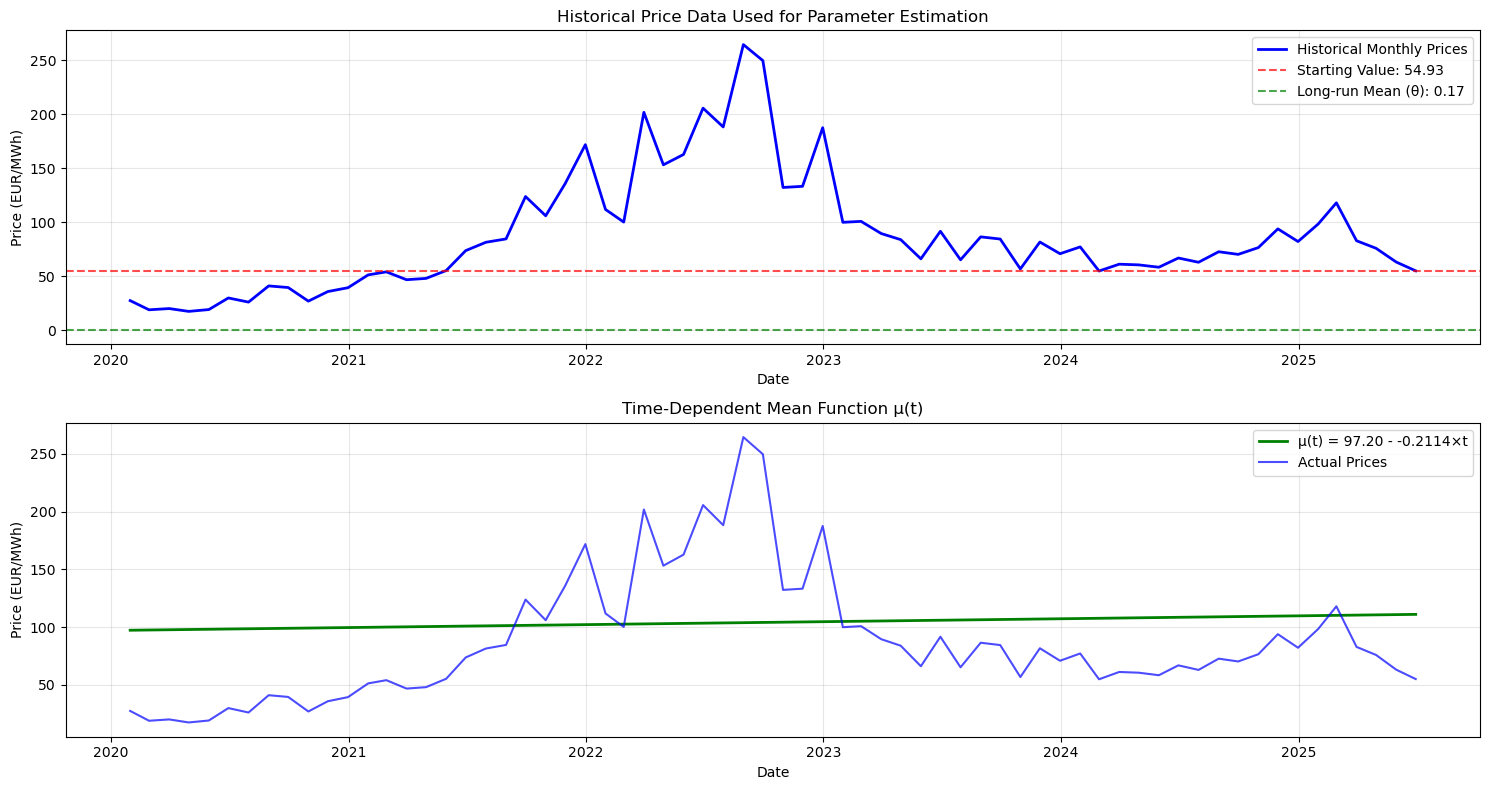

In [19]:
plt.figure(figsize=(15, 8))

# Plot the monthly price data used for estimation
plt.subplot(2, 1, 1)
plt.plot(df_price_monthly.index, df_price_monthly.values, 'b-', linewidth=2, label='Historical Monthly Prices')
plt.axhline(y=start_value, color='red', linestyle='--', alpha=0.7, label=f'Starting Value: {start_value:.2f}')
plt.axhline(y=theta, color='green', linestyle='--', alpha=0.7, label=f'Long-run Mean (θ): {theta:.2f}')
plt.title('Historical Price Data Used for Parameter Estimation')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot the linear trend of mu(t) = a - b*t
plt.subplot(2, 1, 2)
time_indices = np.arange(len(df_price_monthly))
mu_historical = a - b * time_indices
plt.plot(df_price_monthly.index, mu_historical, 'g-', linewidth=2, label=f'μ(t) = {a:.2f} - {b:.4f}×t')
plt.plot(df_price_monthly.index, df_price_monthly.values, 'b-', alpha=0.7, label='Actual Prices')
plt.title('Time-Dependent Mean Function μ(t)')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWh)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

                            AutoReg Model Results                             
Dep. Variable:            DK2_EUR/MWh   No. Observations:                   60
Model:                     AutoReg(1)   Log Likelihood                -286.571
Method:               Conditional MLE   S.D. of innovations             31.131
Date:                Wed, 30 Jul 2025   AIC                            579.143
Time:                        10:38:37   BIC                            585.375
Sample:                    02-29-2020   HQIC                           581.576
                         - 12-31-2024                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.3946      7.522      2.180      0.029       1.652      31.138
DK2_EUR/MWh.L1     0.8279      0.071     11.720      0.000       0.689       0.966
                                    

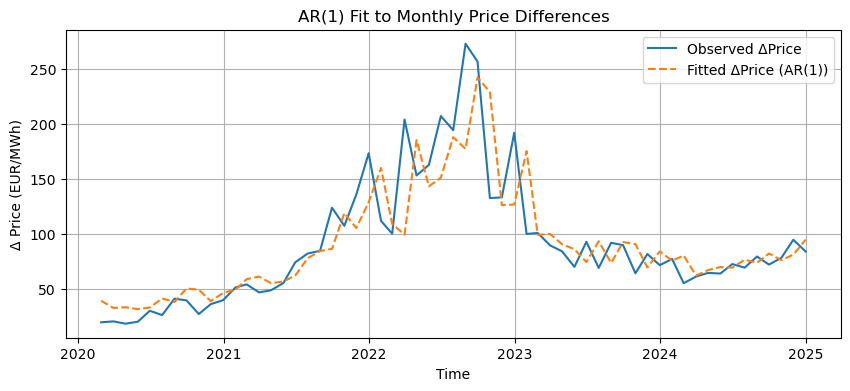

In [ ]:
# AR Model 
from statsmodels.tsa.ar_model import AutoReg

month_lambda = df_clean["DK2_EUR/MWh"][1:].resample('M').mean().dropna()

model = AutoReg(month_lambda, lags=1,trend="c")
results = model.fit()

# Step 3: Print summary
print(results.summary())

# Step 4 (optional): Plot residuals and fitted values
residuals = results.resid
fitted_values = results.fittedvalues

plt.figure(figsize=(10, 4))
plt.plot(month_lambda.index[1:], month_lambda[1:], label="Observed ΔPrice")
plt.plot(month_lambda.index[1:], fitted_values, label="Fitted ΔPrice (AR(1))", linestyle="--")
plt.title("AR(1) Fit to Monthly Price Differences")
plt.xlabel("Time")
plt.ylabel("Δ Price (EUR/MWh)")
plt.legend()
plt.grid(True)

# Step 1: Extract AR(1) parameters
a = results.params['DK2_EUR/MWh.L1']
c = results.params['const']

# Step 2: Compute OU parameters
delta_t = 1  # one month step
kappa = (1 - a) / delta_t
theta = c / (1 - a)
sigma = residuals.std() / np.sqrt(delta_t)

print(f"Estimated OU parameters:")
print(f"  κ (mean reversion speed) = {kappa:.4f}")
print(f"  θ (long-run mean)        = {theta:.4f} EUR/MWh")
print(f"  σ (volatility)           = {sigma:.4f} EUR/MWh")
